In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from pytorch_lightning import LightningModule, Trainer, loggers, callbacks
# from lightning.pytorch.loggers import TensorBoardLogger

from torchvision.models import vgg16
import timm
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pandas as pd

/home/ubuntu/miniconda3/envs/dl-env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class ColorizationDataset(Dataset):
    # data
    def __init__(self, data_folder, data_csv, transform=None):
        """
        Args:
            input_dir (string): Directory with all the input images.
            output_dir (string): Directory with all the target (color) images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data_folder = data_folder
        self.data_path = os.path.join(data_folder, data_csv)
        self.images = pd.read_csv(self.data_path)
        self.transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB by replicating channels
            transforms.Resize((224, 224)),  # Resize to what vit mae takes
            transforms.ToTensor()  # Convert images to PyTorch tensors
        ])
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        sketch, colored = self.images.iloc[idx]
        sketch_image = self.transform(self.__loadImage(sketch))
        colored_image = self.transform(self.__loadImage(colored))
        return sketch_image, colored_image


    def viewImage(self, idx):
        sketch, colored = self.images.iloc[idx]
        return self.__loadImage(sketch), self.__loadImage(colored)

    def __loadImage(self, image_path):
        return Image.open(os.path.join(self.data_folder, image_path))
        
data_folder = 'data/training'
data_csv = 'data.csv'
training_dataset = ColorizationDataset(data_folder, data_csv)

In [3]:
dataloader = DataLoader(training_dataset, batch_size=28, shuffle=True, num_workers=7)

In [4]:
class VGGPerceptualLoss(LightningModule):
    def __init__(self, vgg_model, device='cpu'):
        super().__init__()
        self.vgg = vgg_model
        self.criterion = nn.MSELoss()
        self.features = list(self.vgg.features[:16])
        self.features = nn.Sequential(*self.features).eval().to(device)
        
        for params in self.features.parameters():
            params.requires_grad = False

    def forward(self, x, y):
        return self.criterion(self.features(x),self.features(y))

In [5]:
class Colorizer(LightningModule):
    def __init__(self):
        super().__init__() # this runs the base class's initializer before the current class
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=0)

        self.decoder = nn.Sequential(
            nn.Linear(768, 224 * 224 * 3),
            nn.Unflatten(1, (3, 224,224)),
            nn.Tanh()
        ).to(device)
        vgg_model = vgg16(weights=True)
        self.loss_fn = VGGPerceptualLoss(vgg_model, device=device)

    def forward(self, x):
        features = self.model(x)
        output = self.decoder(features)
        return output

    def configure_optimizers(self):
        self.hparams.learning_rate = 0.0001
        return torch.optim.Adam(filter(lambda p: p.requires_grad, self.parameters()), lr=self.hparams.learning_rate)

    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs)
        loss = self.loss_fn(outputs, targets)
        self.log('train_loss', loss)
        return loss

In [6]:
class FineTuneLearningRateFinder(callbacks.LearningRateFinder):
    def __init__(self, milestones, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.milestones = milestones

    def on_fit_start(self, *args, **kwargs):
        return

    def on_train_epoch_start(self, trainer, pl_module):
        if trainer.current_epoch in self.milestones or trainer.current_epoch == 0:
            self.lr_find(trainer, pl_module)

In [7]:
model = Colorizer()

/home/ubuntu/miniconda3/envs/dl-env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
logger = loggers.TensorBoardLogger("tb_logs")

# trainer = Trainer(callbacks=[FineTuneLearningRateFinder(milestones=(5, 10))], accelerator="gpu", devices=1, max_epochs=30, logger=logger)
trainer = Trainer(accelerator="gpu", devices=1, max_epochs=30, logger=logger)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [17]:
trainer.fit(model, dataloader)

/home/ubuntu/miniconda3/envs/dl-env/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory tb_logs/lightning_logs/version_18/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type              | Params
----------------------------------------------
0 | model   | VisionTransformer | 85.8 M
1 | decoder | Sequential        | 115 M 
2 | loss_fn | VGGPerceptualLoss | 138 M 
----------------------------------------------
338 M     Trainable params
1.7 M     Non-trainable params
339 M     Total params
1,359.649 Total estimated model params size (MB)


Epoch 14:  56%|█████▌    | 2750/4923 [17:42<13:59,  2.59it/s, v_num=18]

/home/ubuntu/miniconda3/envs/dl-env/lib/python3.8/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [10]:
model.eval()
data_folder = 'data/test'
data_csv = 'data.csv'
test_dataset = ColorizationDataset(data_folder, data_csv)

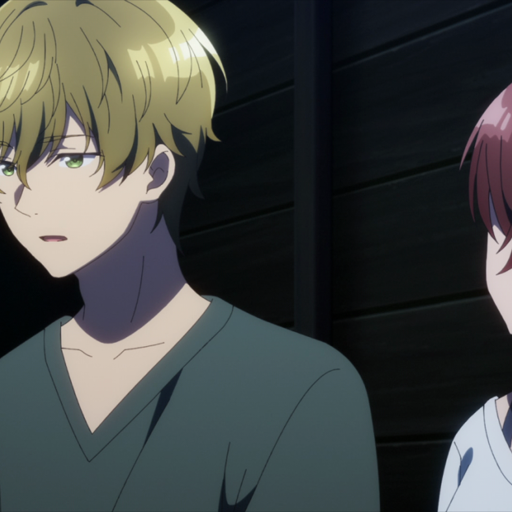

In [33]:
idx = 3000
x, y = test_dataset[idx]
x1, y1 = test_dataset[1]
output = model(x.unsqueeze(0).cuda())
output.squeeze()
input_image, output_image = test_dataset.viewImage(idx)
output_image

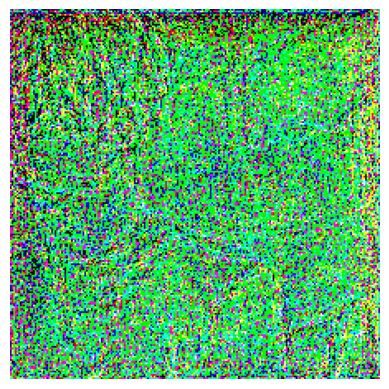

In [34]:
import matplotlib.pyplot as plt

from torchvision.transforms.functional import to_pil_image
# Convert tensor to PIL Image
image = to_pil_image(output.squeeze())

# Display the image
plt.imshow(image)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

In [46]:
!conda install matplotlib -y

Channels:
 - defaults
 - conda-forge
 - nvidia
 - nvidia/label/cuda-12.4.1
 - pytorch
Platform: linux-64
Solving environment: done

## Package Plan ##

  environment location: /home/ubuntu/miniconda3/envs/dl-env

  added / updated specs:
    - matplotlib


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    brotli-1.0.9               |       h5eee18b_7          18 KB
    brotli-bin-1.0.9           |       h5eee18b_7          19 KB
    contourpy-1.0.5            |   py38hdb19cb5_0         203 KB
    cycler-0.11.0              |     pyhd3eb1b0_0          12 KB
    cyrus-sasl-2.1.28          |       h52b45da_1         237 KB
    dbus-1.13.18               |       hb2f20db_0         504 KB
    expat-2.6.2                |       h6a678d5_0         177 KB
    fontconfig-2.14.1          |       h4c34cd2_2         281 KB
    fonttools-4.51.0           |   py38h5eee18b_0         2.3 MB
    glib-2.78.

In [36]:
linearLayer = nn.Linear(768,224 * 224 * 3)

In [37]:
linearLayer

Linear(in_features=768, out_features=150528, bias=True)

In [40]:
nn.Unflatten(1,(3,224,224))

Unflatten(dim=1, unflattened_size=(3, 224, 224))

In [41]:
?? nn.Unflatten

Init signature:
 nn.Unflatten(
    dim: Union[int, str],
    unflattened_size: Union[torch.Size, List[int], Tuple[int, ...], Tuple[Tuple[str, int]]],
) -> None
Source:        
class Unflatten(Module):
    r"""
    Unflattens a tensor dim expanding it to a desired shape. For use with :class:`~nn.Sequential`.

    * :attr:`dim` specifies the dimension of the input tensor to be unflattened, and it can
      be either `int` or `str` when `Tensor` or `NamedTensor` is used, respectively.

    * :attr:`unflattened_size` is the new shape of the unflattened dimension of the tensor and it can be
      a `tuple` of ints or a `list` of ints or `torch.Size` for `Tensor` input;  a `NamedShape`
      (tuple of `(name, size)` tuples) for `NamedTensor` input.

    Shape:
        - Input: :math:`(*, S_{\text{dim}}, *)`, where :math:`S_{\text{dim}}` is the size at
          dimension :attr:`dim` and :math:`*` means any number of dimensions including none.
        - Output: :math:`(*, U_1, ..., U_n, *)`, 